In [1]:
import os
import time
import math
import json
import warnings
from typing import Tuple, Optional, Dict, Any

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 60)

def log(msg: str):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}")

In [4]:
VALIDATED_PATH = "data/02_qaqc/osm_amenities_validated.parquet"
FLAGS_PATH = "data/02_qaqc/osm_amenities_qaqc_flags.parquet"

gdf = gpd.read_parquet(VALIDATED_PATH)
log(f"Loaded validated: {gdf.shape}, CRS={gdf.crs}")

flags = None
if os.path.exists(FLAGS_PATH):
    flags = pd.read_parquet(FLAGS_PATH)
    log(f"Loaded flags: {flags.shape}")
else:
    log("QA flags not found (optional). Proceeding without flags.")

gdf.head(3)

[12:47:34] Loaded validated: (1793, 18), CRS={"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "WGS 84 / Pseudo-Mercator", "base_crs": {"name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic long

,osm_type,osm_id,amenity,name,operator,brand,addr_city,addr_street,addr_housenumber,addr_postcode,full_address,website,phone,lat,lon,nn_dist_m,raw_tags,geometry
0,node,10688464885,fuel,Socar,SOCAR Energy Ukraine,Socar,None,бульвар Миколи Міхновського,35,None,"бульвар Миколи Міхновського, 35",https://socar.ua/,+380 67 462 3221,50.423116,30.554046,193.606449,"{""addr:housenumber"": ""35"", ""addr:street"": ""бул...",POINT (3401260.842 6519877.12)
1,way,554546852,fuel,Socar,SOCAR Energy Ukraine,SOCAR,None,вулиця Протасів Яр,15,None,"вулиця Протасів Яр, 15",https://socar.com.ua/,+380 67 470 7754,50.425165,30.500465,178.536594,"{""addr:housenumber"": ""15"", ""addr:street"": ""вул...",POINT (3395296.222 6520235.174)
2,way,528884957,fuel,ОККО,ОККО,ОККО,None,Богатирська вулиця,2-Е,None,"Богатирська вулиця, 2-Е",https://www.okko.ua/,+380 44 428 3695,50.507856,30.484007,279.325921,"{""addr:housenumber"": ""2-Е"", ""addr:street"": ""Бо...",POINT (3393464.103 6534696.484)


In [5]:
if gdf.crs is None:
    raise ValueError("CRS missing.")
gdf_wgs = gdf.to_crs("EPSG:4326").copy()
gdf_proj = gdf.to_crs("EPSG:3857").copy()

coords_m = np.vstack([gdf_proj.geometry.x.values, gdf_proj.geometry.y.values]).T
log("Prepared projected coordinates for spatial features.")

[12:47:36] Prepared projected coordinates for spatial features.


In [6]:
from sklearn.neighbors import NearestNeighbors

def knn_features(coords: np.ndarray, k: int = 6) -> pd.DataFrame:
    """
    KNN-based features:
    - mean distance to K neighbors
    - median distance to K neighbors
    - distance to nearest neighbor
    """
    nn = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(coords)
    dists, _ = nn.kneighbors(coords)
    # dists[:,0] is self=0
    out = pd.DataFrame({
        "nn1_m": dists[:, 1],
        "nn_mean_k_m": dists[:, 1:].mean(axis=1),
        "nn_median_k_m": np.median(dists[:, 1:], axis=1),
        "nn_max_k_m": dists[:, 1:].max(axis=1),
    })
    return out

knn_df = knn_features(coords_m, k=8)
knn_df.describe()

,nn1_m,nn_mean_k_m,nn_median_k_m,nn_max_k_m
count,1793.000000,1793.000000,1793.000000,1793.000000
mean,187.415090,438.577139,455.981606,637.817578
std,166.066637,223.395611,246.834308,295.634414
min,1.852158,80.666315,22.225283,120.121732
25%,71.192974,295.184570,291.499597,439.104894
50%,154.340833,399.012428,405.751757,595.736308
75%,258.473665,537.177683,564.365005,777.165769
max,1943.385882,2630.244939,2481.912440,3166.478777


In [7]:
from sklearn.neighbors import BallTree

def radius_density(coords: np.ndarray, radii_m=(250, 500, 1000)) -> pd.DataFrame:
    tree = BallTree(coords, metric="euclidean")
    out = {}
    for r in radii_m:
        inds = tree.query_radius(coords, r=r)
        # subtract self
        out[f"count_within_{r}m"] = np.array([max(0, len(ix)-1) for ix in inds], dtype=int)
    return pd.DataFrame(out)

dens_df = radius_density(coords_m, radii_m=(250, 500, 1000, 2000))
dens_df.head()

,count_within_250m,count_within_500m,count_within_1000m,count_within_2000m
0,1,2,9,53
1,1,1,6,39
2,0,2,14,55
3,1,3,15,53
4,0,0,6,20


In [8]:
def distance_to_nearest_by_category(gdf_proj: gpd.GeoDataFrame, category_col="amenity",
                                   categories=("hospital","pharmacy","police")) -> pd.DataFrame:
    out = pd.DataFrame(index=gdf_proj.index)
    base_coords = np.vstack([gdf_proj.geometry.x.values, gdf_proj.geometry.y.values]).T

    for cat in categories:
        mask = (gdf_proj[category_col] == cat).values
        if mask.sum() < 2:
            out[f"dist_to_{cat}_m"] = np.nan
            continue

        cat_coords = np.vstack([gdf_proj.loc[mask].geometry.x.values, gdf_proj.loc[mask].geometry.y.values]).T
        nn = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(cat_coords)
        d, _ = nn.kneighbors(base_coords)
        out[f"dist_to_{cat}_m"] = d[:, 0]
    return out

dist_cat_df = distance_to_nearest_by_category(
    gdf_proj, categories=("hospital","pharmacy","fuel","school")
)
dist_cat_df.describe()

,dist_to_hospital_m,dist_to_pharmacy_m,dist_to_fuel_m,dist_to_school_m
count,1793.000000,1793.000000,1793.000000,1793.000000
mean,1623.520257,185.545354,1043.015152,422.490900
std,1532.209900,317.797618,728.824137,364.835543
min,0.000000,0.000000,0.000000,0.000000
25%,575.007024,0.000000,535.609229,162.073915
50%,1159.325863,0.000000,973.675058,378.230367
75%,2198.172638,290.409336,1436.371011,595.233097
max,8415.468945,2481.912440,3679.676047,2436.840125


In [9]:
feat = pd.DataFrame(index=gdf.index)

# basic attributes
feat["amenity"] = gdf["amenity"].astype("string")
feat["has_name"] = gdf["name"].notna().astype(int)
feat["has_address"] = gdf.get("full_address", pd.Series([None]*len(gdf))).notna().astype(int)

# geometry-based
feat = pd.concat([feat, knn_df, dens_df, dist_cat_df], axis=1)

# optionally include nn_dist_m if already computed
if "nn_dist_m" in gdf.columns:
    feat["nn_dist_m"] = gdf["nn_dist_m"].astype(float)

log(f"Feature store shape: {feat.shape}")
feat.head()

[12:48:25] Feature store shape: (1793, 16)


,amenity,has_name,has_address,nn1_m,nn_mean_k_m,nn_median_k_m,nn_max_k_m,count_within_250m,count_within_500m,count_within_1000m,count_within_2000m,dist_to_hospital_m,dist_to_pharmacy_m,dist_to_fuel_m,dist_to_school_m,nn_dist_m
0,fuel,1,1,193.606449,639.046528,785.389424,909.182719,1,2,9,53,336.524118,909.182719,0.0,785.389424,193.606449
1,fuel,1,1,178.536594,801.237985,897.249123,1001.969249,1,1,6,39,178.536594,897.249123,0.0,842.141240,178.536594
2,fuel,1,1,279.325921,601.328274,664.554945,777.504590,0,2,14,55,1864.252430,721.175164,0.0,810.520835,279.325921
3,fuel,1,1,109.266429,487.324731,549.903931,794.587386,1,3,15,53,2024.211121,298.256521,0.0,549.903931,109.266429
4,fuel,1,1,590.786825,907.227006,925.846636,1287.808189,0,0,6,20,1840.208106,708.819988,0.0,899.878407,590.786825


In [10]:
target = "has_address"
y = feat[target].astype(int).values

# drop leakage columns
X = feat.drop(columns=[target]).copy()

cat_cols = ["amenity"]
num_cols = [c for c in X.columns if c not in cat_cols]

log(f"X shape: {X.shape} | y mean: {y.mean():.3f}")

[12:48:36] X shape: (1793, 15) | y mean: 0.285


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
log(f"Train: {X_train.shape} | Test: {X_test.shape}")

[12:48:44] Train: (1344, 15) | Test: (449, 15)


In [12]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None))
])

rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

models = {"LogReg": lr, "RandomForest": rf}

In [13]:
results = []
trained = {}

for name, model in models.items():
    log(f"Training: {name}")
    model.fit(X_train, y_train)
    trained[name] = model

    proba = model.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)

    results.append({"model": name, "roc_auc": auc, "avg_precision": ap})

pd.DataFrame(results).sort_values("roc_auc", ascending=False)

[12:49:06] Training: LogReg
[12:49:06] Training: RandomForest


,model,roc_auc,avg_precision
0,LogReg,0.681440,0.483882
1,RandomForest,0.635027,0.421160


In [15]:
best_name = sorted(results, key=lambda x: x["roc_auc"], reverse=True)[0]["model"]
best_model = trained[best_name]

log(f"Best model: {best_name}")

proba = best_model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print(classification_report(y_test, pred, digits=4))
confusion_matrix(y_test, pred)

[12:49:32] Best model: LogReg
              precision    recall  f1-score   support

           0     0.7532    0.9221    0.8291       321
           1     0.5536    0.2422    0.3370       128

    accuracy                         0.7283       449
   macro avg     0.6534    0.5822    0.5830       449
weighted avg     0.6963    0.7283    0.6888       449



array([[296,  25],
       [ 97,  31]])

In [16]:
if best_name == "RandomForest":
    # Extract feature names after encoding
    ohe = best_model.named_steps["prep"].named_transformers_["cat"]
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
    feature_names = cat_feature_names + num_cols

    importances = best_model.named_steps["clf"].feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

    fi.head(20)

In [18]:
if best_name == "RandomForest":
    plt.figure()
    top = fi.head(15)
    plt.bar(top["feature"], top["importance"])
    plt.xticks(rotation=70, ha="right")
    plt.title("Top feature importances (RandomForest)")
    plt.tight_layout()
    plt.show()

In [19]:
if best_name == "LogReg":
    ohe = best_model.named_steps["prep"].named_transformers_["cat"]
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
    feature_names = cat_feature_names + num_cols

    coefs = best_model.named_steps["clf"].coef_[0]
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)
    coef_df.head(20)

In [20]:
# Use numeric spatial features for anomaly detection
anom_cols = [c for c in feat.columns if c not in ["amenity"]]
anom_df = feat[anom_cols].fillna(0).copy()

scaler = StandardScaler()
Z = scaler.fit_transform(anom_df.values)

iso = IsolationForest(
    n_estimators=400,
    contamination=0.08,  # demo
    random_state=42
)
iso.fit(Z)
score_raw = -iso.decision_function(Z)  # higher = more anomalous

# Normalize to 0..1 for GIS-friendly "priority"
priority = (score_raw - score_raw.min()) / (score_raw.max() - score_raw.min() + 1e-9)

feat["priority_score"] = priority
feat["priority_bucket"] = pd.qcut(feat["priority_score"], q=5, labels=["Very Low","Low","Medium","High","Very High"])

feat[["priority_score","priority_bucket"]].head()

,priority_score,priority_bucket
0,0.295015,Very High
1,0.348873,Very High
2,0.216815,High
3,0.151207,Medium
4,0.445542,Very High


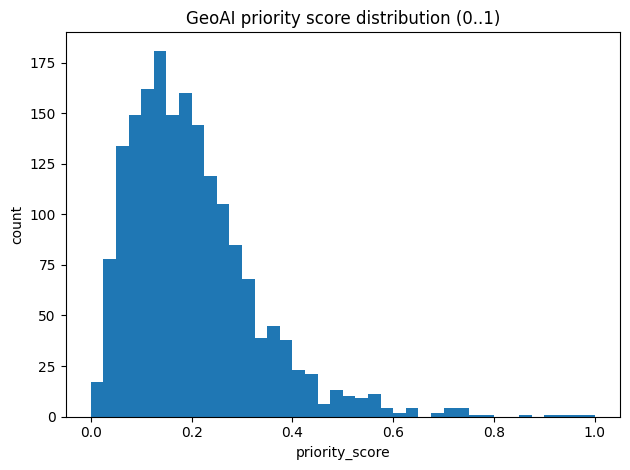

In [21]:
plt.figure()
plt.hist(feat["priority_score"], bins=40)
plt.title("GeoAI priority score distribution (0..1)")
plt.xlabel("priority_score")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [22]:
gdf_out = gdf_wgs.copy()

# Add ML outputs
gdf_out["ml_has_address_proba"] = best_model.predict_proba(X)[:, 1]
gdf_out["priority_score"] = feat["priority_score"].values
gdf_out["priority_bucket"] = feat["priority_bucket"].astype(str).values

# Optional: add a compact explain field
gdf_out["geoai_notes"] = (
    "Demo GeoAI scoring. Higher score = spatial anomaly / coverage gap proxy."
)

gdf_out.head(3)

,osm_type,osm_id,amenity,name,operator,brand,addr_city,addr_street,addr_housenumber,addr_postcode,full_address,website,phone,lat,lon,nn_dist_m,raw_tags,geometry,ml_has_address_proba,priority_score,priority_bucket,geoai_notes
0,node,10688464885,fuel,Socar,SOCAR Energy Ukraine,Socar,None,бульвар Миколи Міхновського,35,None,"бульвар Миколи Міхновського, 35",https://socar.ua/,+380 67 462 3221,50.423116,30.554046,193.606449,"{""addr:housenumber"": ""35"", ""addr:street"": ""бул...",POINT (30.55405 50.42312),0.585174,0.295015,Very High,Demo GeoAI scoring. Higher score = spatial ano...
1,way,554546852,fuel,Socar,SOCAR Energy Ukraine,SOCAR,None,вулиця Протасів Яр,15,None,"вулиця Протасів Яр, 15",https://socar.com.ua/,+380 67 470 7754,50.425165,30.500465,178.536594,"{""addr:housenumber"": ""15"", ""addr:street"": ""вул...",POINT (30.50046 50.42517),0.597256,0.348873,Very High,Demo GeoAI scoring. Higher score = spatial ano...
2,way,528884957,fuel,ОККО,ОККО,ОККО,None,Богатирська вулиця,2-Е,None,"Богатирська вулиця, 2-Е",https://www.okko.ua/,+380 44 428 3695,50.507856,30.484007,279.325921,"{""addr:housenumber"": ""2-Е"", ""addr:street"": ""Бо...",POINT (30.48401 50.50786),0.555752,0.216815,High,Demo GeoAI scoring. Higher score = spatial ano...


In [23]:
OUT_DIR = "data/04_geoai"
os.makedirs(OUT_DIR, exist_ok=True)

features_path = os.path.join(OUT_DIR, "features.parquet")
preds_path = os.path.join(OUT_DIR, "predictions.parquet")
geojson_path = os.path.join(OUT_DIR, "geoai_scored.geojson")
gpkg_path = os.path.join(OUT_DIR, "geoai_scored.gpkg")

feat.to_parquet(features_path, index=False)
log(f"Saved feature store: {features_path}")

gdf_out.drop(columns=["geometry"]).to_parquet(preds_path, index=False)
log(f"Saved predictions table: {preds_path}")

gdf_out.to_file(geojson_path, driver="GeoJSON")
log(f"Saved GeoJSON layer: {geojson_path}")

gdf_out.to_file(gpkg_path, driver="GPKG", layer="geoai_scored")
log(f"Saved GeoPackage layer: {gpkg_path}")

[12:51:18] Saved feature store: data/04_geoai/features.parquet
[12:51:18] Saved predictions table: data/04_geoai/predictions.parquet
[12:51:19] Saved GeoJSON layer: data/04_geoai/geoai_scored.geojson
[12:51:19] Saved GeoPackage layer: data/04_geoai/geoai_scored.gpkg


In [24]:
md = f"""
## GeoAI Baseline Outputs

**Artifacts**
- Feature store: `{features_path}`
- Predictions: `{preds_path}`
- GIS-ready layer (GeoJSON): `{geojson_path}`
- GIS-ready layer (GPKG): `{gpkg_path}`

**Fields added**
- `ml_has_address_proba`: baseline ML probability (demo target)
- `priority_score`: unsupervised anomaly/coverage-based score (0..1)
- `priority_bucket`: quantile-based category for symbology / dashboard filters
"""
print(md)


## GeoAI Baseline Outputs

**Artifacts**
- Feature store: `data/04_geoai/features.parquet`
- Predictions: `data/04_geoai/predictions.parquet`
- GIS-ready layer (GeoJSON): `data/04_geoai/geoai_scored.geojson`
- GIS-ready layer (GPKG): `data/04_geoai/geoai_scored.gpkg`

**Fields added**
- `ml_has_address_proba`: baseline ML probability (demo target)
- `priority_score`: unsupervised anomaly/coverage-based score (0..1)
- `priority_bucket`: quantile-based category for symbology / dashboard filters



In [ ]:
from arcgis.gis import GIS

ARCGIS_URL = os.getenv("ARCGIS_URL", "https://www.arcgis.com")
ARCGIS_USERNAME = os.getenv("ARCGIS_USERNAME")
ARCGIS_PASSWORD = os.getenv("ARCGIS_PASSWORD")

if ARCGIS_USERNAME and ARCGIS_PASSWORD:
    gis = GIS(ARCGIS_URL, ARCGIS_USERNAME, ARCGIS_PASSWORD)
    log(f"Connected: {gis.users.me.username}")
else:
    log("ArcGIS credentials not found. Skipping portal publishing.")

In [ ]:
if "gis" in globals():
    sdf_scored = pd.DataFrame.spatial.from_geodataframe(gdf_out)
    sdf_scored = sdf_scored.drop(columns=["raw_tags"], errors="ignore")  # safer

    TITLE_SCORED = "GeoAI Scored Layer — OSM Amenities (Demo)"
    item_scored = gis.content.import_data(sdf_scored, title=TITLE_SCORED)
    fl_scored = item_scored.publish() if item_scored.type != "Feature Layer" else item_scored

    print("Scored layer URL:", f"{gis.url}/home/item.html?id={fl_scored.itemid}")